# Test experimental model

This notebook tests the model used for experimental cells runs correctly on a simple step stimulus.

In [1]:
import json
import sys
import os
import time
import neuron
from pathlib import Path
import time

import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import numpy as np

import shutil
from pprint import pprint

import multimodalfitting as mf

import neuroplotlib as nplt

%matplotlib notebook

In [2]:
model_name = "experimental" # "hay", "hay_ais", "hay_ais_hillock"
probe_type = "planar"
base_folder = Path("../..")
cell_models_folder = base_folder / "cell_models"

model_folder = cell_models_folder / f"{model_name}_model"
data_folder = base_folder / "data_210916" / "experimental" / "cell1_210301"

In [3]:
morphology = data_folder / "morphology" / "morphology_corrected.swc"
probe_file = data_folder / "extracellular" / "probe.json"
params_release = "experimental_model/parameters_abd_release.json"

In [10]:
cell = mf.create_experimental_model(morphology_file=morphology,
                                    cell_model_folder=model_folder,
                                    release=True,
                                    v_init=-80, 
                                    abd=False)
cell_abd = mf.create_experimental_model(morphology_file=morphology,
                                    cell_model_folder=model_folder,
                                    release=True,
                                    v_init=-80, 
                                    abd=True)

Setting v_init to -80
Setting v_init to -80


In [11]:
# define a probe (this can also be defined externally)
probe = mf.define_electrode(probe_file=probe_file)

# define a test protocol
protocols = mf.define_test_step_protocol(step_amplitude=3.5, tot_duration=500, step_duration=400, probe=probe)

# instantiate simulator
sim = ephys.simulators.LFPySimulator(cell, cvode_active=True, electrode=probe, mechs_folders=model_folder)
sim_abd = ephys.simulators.LFPySimulator(cell_abd, cvode_active=True, electrode=probe, mechs_folders=model_folder)

In [12]:
t_start = time.time()
responses = protocols["TestStep"].run(cell, param_values={}, sim=sim)
print(f"Elapsed time: {time.time() - t_start}")

Can't run define_shape() since some connection are not at the end points of section
Elapsed time: 12.584408044815063


<IPython.core.display.Javascript object>


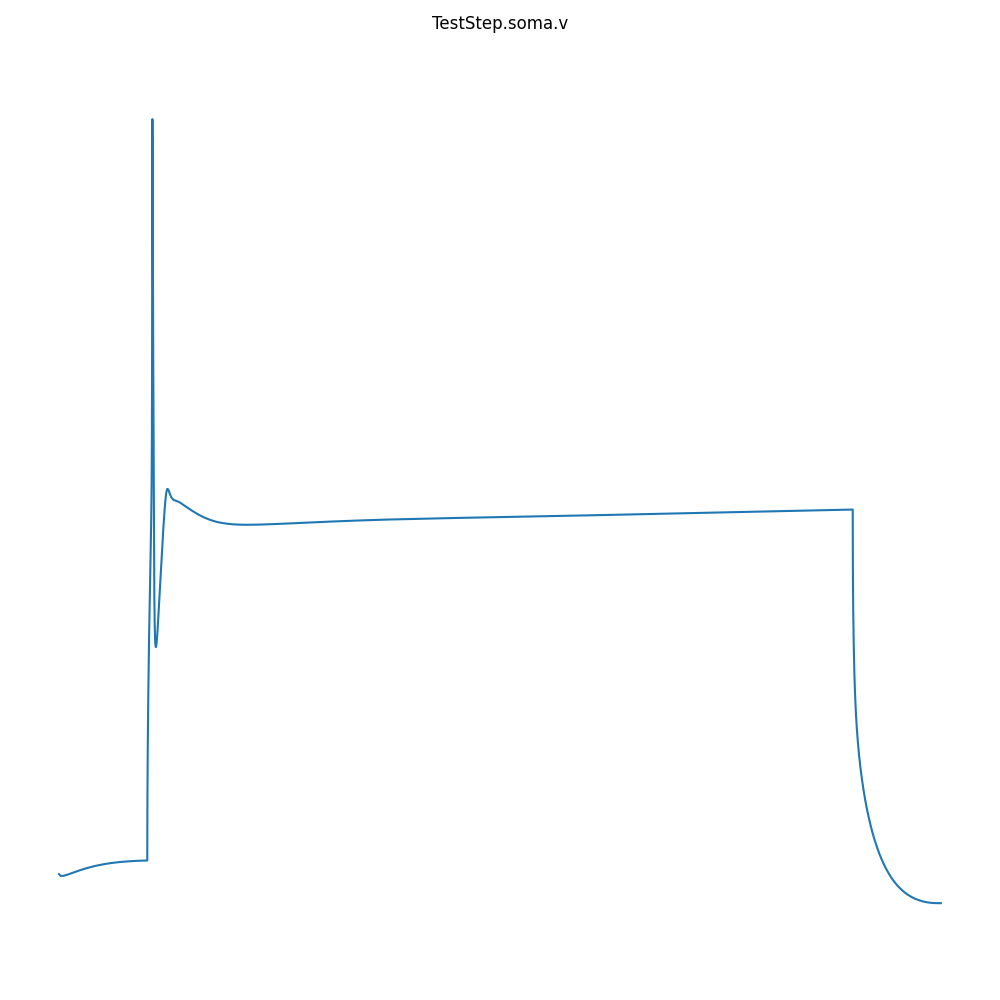

In [13]:
mf.plot_responses(responses)

In [14]:
t_start = time.time()
responses_abd = protocols["TestStep"].run(cell_abd, param_values={}, sim=sim_abd)
print(f"Elapsed time: {time.time() - t_start}")

experimental[0].dend[1]
experimental[0].dend[0]
Adding
0 experimental[0].dend[0] is now experimental[0].abd[0]
Parent: Connecting experimental[0].abd[0] 0.0 to experimental[0].soma[0]0.5
Children
Connecting experimental[0].abd[0]1.0 to experimental[0].dend[29]0.0
Connecting experimental[0].abd[0]1.0 to experimental[0].dend[1]0.0
1 experimental[0].dend[1] is now experimental[0].abd[1]
Parent: Connecting experimental[0].abd[1] 0.0 to experimental[0].abd[0]1.0
Children
Connecting experimental[0].abd[1]1.0 to experimental[0].ais[0]0.0
Connecting experimental[0].abd[1]1.0 to experimental[0].dend[2]0.0
Added section experimental[0].abd[0]
Start 310.964599609375,223.066162109375 --  End 289.3557434082031,229.59384155273438
Added section experimental[0].abd[1]
Start 289.3557434082031,229.59384155273438 --  End 280.0144348144531,232.18238830566406
Can't run define_shape() since some connection are not at the end points of section
start experimental[0].abd[0] 310.964599609375 223.066162109375
en

<IPython.core.display.Javascript object>


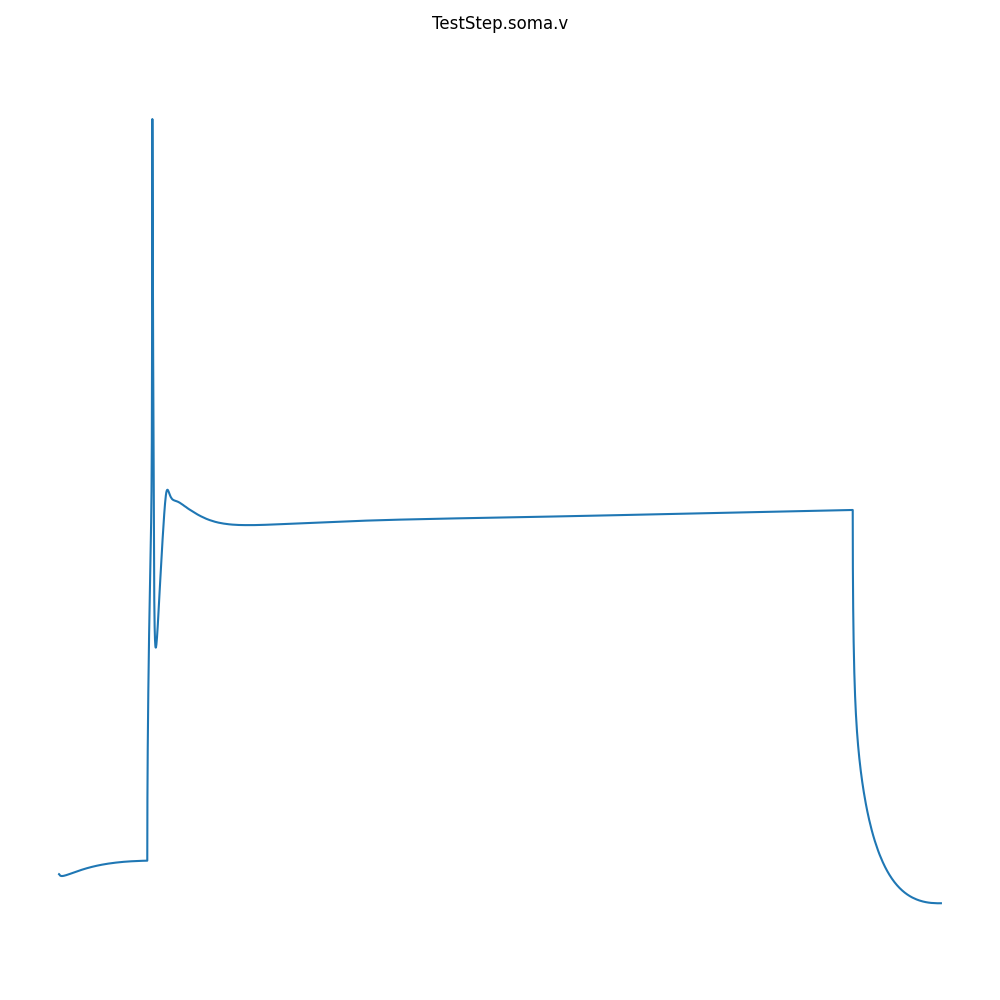

In [16]:
mf.plot_responses(responses_abd)

### Check morphology and probe

In [ ]:
plt.show()

In [ ]:
ax = mf.plot_probe(probe, interactive=True)

In [ ]:
ax = mf.plot_cell(cell, sim, color="k", color_ais="g", color_dend="r", detailed=False, ax=ax, 
                  exclude_sections=["soma"])

In [ ]:
ax = mf.plot_cell(cell, sim, color="k", color_ais="g", color_dend="r", color_abd="b", detailed=False, 
                  exclude_sections=["soma"])

## Check channel distributions

In [ ]:
print("No abd")
cell.freeze({})
cell.instantiate(sim)

In [ ]:
sim.neuron.h.topology()

In [ ]:
from multimodalfitting.imaging_tools.correct_swc import swc_dtype

In [ ]:
swc_data = np.loadtxt(morphology, dtype=swc_dtype)

In [ ]:
x_c = swc_data["x"] - swc_data["x"][0]
y_c = swc_data["y"] - swc_data["y"][0]

In [ ]:
ax = nplt.plot_neuron(cell.LFPyCell, plane="xy", color_ais="g", color_axon="r",
                      color_abd="b", exclude_sections=["soma"])

In [ ]:
swc_data["x"][:10]

In [ ]:
x_c[:10]

In [ ]:
ax.plot(x_c, y_c, ls="", marker=".", color='r')

In [ ]:
sec_to_show = ["[0].dend[29]", "[0].dend[2]", "[0].dend[0]", "[0].dend[1]",
               "[0].abd"]

for sec in cell.LFPyCell.allseclist:
    name = sec.name()
    if any([sec_ in name for sec_ in sec_to_show]):
        n3d = sec.n3d()
        print(f"{name} - pos0: {[sec.x3d(0), sec.y3d(0)]}, pos0: {[sec.x3d(n3d - 1), sec.y3d(n3d - 1)]}")
        print(sim.neuron.h.parent_connection(sec), sim.neuron.h.parent_section(sec))

In [ ]:
for sec in cell.LFPyCell.allseclist:
    name = sec.name()
    if "dend[0]" in name:
        break

In [ ]:
sec.psection()["morphology"]["parent"]

In [ ]:
sec.parentseg().sec

In [ ]:
cell.icell.ais[0].psection()["morphology"]["parent"]

In [ ]:
cell.icell.axon[0].psection()["morphology"]["parent"]

In [ ]:
cell.icell.dend[1].x3d(cell.icell.dend[1].n3d() - 1)

In [ ]:
sim.neuron.h.parent_connection(sec=sec)

In [ ]:
sec.x3d(sec.n3d() - 1)

In [ ]:
print("Parent section:", sec.parentseg().sec)
print("Parent end:", sim.neuron.h.parent_connection(sec=sec))

In [ ]:
children_abd = sec.children()

In [ ]:
sim.neuron.h.parent_connection(sec=children_abd[1])

In [ ]:
children_abd[0].parentseg().x

In [ ]:
cell.unfreeze({})
cell.destroy(sim)

In [ ]:
print("abd")
cell_abd.freeze({})
cell_abd.instantiate(sim)

In [ ]:
debug

In [ ]:
sim_abd.neuron.h.topology()

In [ ]:
for sec in cell.LFPyCell.allseclist:
    name = sec.name()
    if "abd[0]" in name:
        break

In [ ]:
sec.psection()

In [ ]:
cell_abd.icell.dend[70].parentseg().x

In [ ]:
ax = nplt.plot_neuron(cell_abd.LFPyCell, plane="xy", color_ais="g", color_abd="b", exclude_sections=["soma"],
                      detailed=True)

In [ ]:
cell_abd.icell.soma[0].nseg

In [ ]:
ax.plot(x_c, y_c, ls="", marker=".", color='r')

In [ ]:
sec_to_show = ["[0].dend[29]", "[0].dend[2]", "[0].dend[0]", "[0].dend[1]",
               "[0].abd", ]

for sec in cell_abd.LFPyCell.allseclist:
    name = sec.name()
    if any([sec_ in name for sec_ in sec_to_show]):
        n3d = sec.n3d()
        print(f"{name} - pos0: {[sec.x3d(0), sec.y3d(0)]}, pos0: {[sec.x3d(n3d - 1), sec.y3d(n3d - 1)]}")
        

In [ ]:
cell_abd.unfreeze({})
cell_abd.destroy(sim)

In [ ]:
lfpy_cell = cell.LFPyCell:
for sec in lfpy_cell.allseclist:
    if "ais" in sec.name():
        break
ais = sec

In [ ]:
plt.figure()
ais_dist = np.linspace(0, ais.L, ais.nseg)
plt.plot(ais_dist, ais.psection()["density_mechs"]["Na16Hu2009"]["gNa16bar"], label="gNa16bar_Na16Hu2009")
plt.plot(ais_dist, ais.psection()["density_mechs"]["Na12Hu2009"]["gNa12bar"], label="gNa12bar_Na12Hu2009")
plt.plot(ais_dist, ais.psection()["density_mechs"]["KdShu2007"]["gkbar"], label="gkbar_KdShu2007")

In [ ]:
dend_list = []
for sec in lfpy_cell.allseclist:
    if "dend" in sec.name():
        dend_list.append(sec)

In [ ]:
plt.figure()
for dend in dend_list:
    start_ = np.array([dend.x3d(0), dend.y3d(0), dend.x3d(0)])
    if dend.nseg > 1:
        start_dist = np.linalg.norm(start_)
        end_dist = start_dist + dend.L
        linear_dist_to_soma = np.linspace(start_dist, end_dist, dend.nseg)        
    else:
        linear_dist_to_soma = [np.linalg.norm(start_) + dend.L // 2]

    plt.plot(linear_dist_to_soma, dend.psection()["density_mechs"]["NaTg"]["gNaTgbar"], "b*")

In [ ]:
cell.unfreeze({})
cell.destroy(sim)